# Heterogeneous Array Mosaic Simulations and Imaging

In [1]:
import os
#os.system("pip install sirius==0.0.13")

print('complete')

complete


In [2]:
import pkg_resources
import xarray as xr
import numpy as np
from astropy.coordinates import SkyCoord
xr.set_options(display_style="html")
import os
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
except:
    IN_COLAB = False
%matplotlib widget 

## Telescope Layout

In [3]:
########## Get telescope layout ##########
tel_dir = pkg_resources.resource_filename('sirius_data', 'telescope_layout/data/alma.all.tel.zarr')
tel_xds = xr.open_zarr(tel_dir,consolidated=False).sel(ant_name = ['N601','N606','J505','J510', 'A001', 'A012','A025', 'A033','A045', 'A051','A065', 'A078'])
n_ant = tel_xds.dims['ant_name']
tel_xds

<xarray.Dataset>
Dimensions:        (ant_name: 12, pos_coord: 3)
Coordinates:
  * ant_name       (ant_name) <U7 'N601' 'N606' 'J505' ... 'A051' 'A065' 'A078'
  * pos_coord      (pos_coord) int64 0 1 2
Data variables:
    ANT_POS        (ant_name, pos_coord) float64 dask.array<chunksize=(12, 3), meta=np.ndarray>
    DISH_DIAMETER  (ant_name) float64 dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    site_pos:        [{'m0': {'unit': 'm', 'value': 2225142.180268967}, 'm1':...
    telescope_name:  ALMA

## Create Time and Freq Xarrays
The chunking of time_xda and chan_xda determines the number of branches in the DAG (maximum parallelism = n_time_chunks x n_chan_chunks).

In [4]:
from sirius.simulation import make_time_xda


#time_xda = make_time_xda(time_start='2020-10-03T18:56:36.44',time_delta=2000,n_samples=18,n_chunks=4)
#time_xda = make_time_xda(time_start='2020-10-03T18:57:29.09',time_delta=2000,n_samples=18,n_chunks=4)
#time_xda = make_time_xda(time_start='2020-10-04T00:00:00.000',time_delta=2000,n_samples=18,n_chunks=4)

time_xda = make_time_xda(time_start='2020-10-03T18:57:28.95',time_delta=2000,n_samples=18,n_chunks=4)
time_xda

Number of chunks  4


<xarray.DataArray 'array-9a5bea46ecb1a18f8ae07c9f9a7216da' (time: 18)>
dask.array<array, shape=(18,), dtype=<U23, chunksize=(5,), chunktype=numpy.ndarray>
Dimensions without coordinates: time
Attributes:
    time_delta:  2000.0

In [5]:
from sirius.simulation import make_chan_xda
chan_xda = make_chan_xda(spw_name = 'Band3',freq_start = 90*10**9, freq_delta = 2*10**9, freq_resolution=1*10**6, n_channels=5, n_chunks=3)
chan_xda

Number of chunks  3


<xarray.DataArray 'array-2640390bae5211a378385263c62dfc3a' (chan: 5)>
dask.array<array, shape=(5,), dtype=float64, chunksize=(2,), chunktype=numpy.ndarray>
Dimensions without coordinates: chan
Attributes:
    freq_resolution:  1000000.0
    spw_name:         Band3

Beam Models

In [6]:
#Get 1GHz max rad values from https://open-bitbucket.nrao.edu/projects/CASA/repos/casa6/browse/casa5/code/synthesis/TransformMachines/PBMath.cc
#Values is in degrees. Convert to radians.
airy_disk_parms_alma =  {'pb_func':'casa_airy','dish_diam':10.7,'blockage_diam':0.75,'max_rad_1GHz':1.784*np.pi/180}
airy_disk_parms_aca =  {'pb_func':'casa_airy','dish_diam':6.25,'blockage_diam':0.75,'max_rad_1GHz':3.568*np.pi/180}

beam_models = [airy_disk_parms_aca, airy_disk_parms_alma]

# beam_model_map maps the antenna index to a model in beam_models.
beam_model_map = tel_xds.DISH_DIAMETER.values  
beam_model_map[beam_model_map == 7] = 0
beam_model_map[beam_model_map == 12] = 1
beam_model_map= beam_model_map.astype(int)

beam_parms = {} #Use default beam parms.

#If no beam should be used:
#none_model = {'pb_func':'none','dish_diameter':0.0,'blockage_diameter':0.0}

#If Zernike Polynomial should be used:
#zpc_dir = pkg_resources.resource_filename('sirius_data', 'dish_models/data/EVLA_avg_zcoeffs_SBand_lookup.zpc.zarr')
#zpc_xds.attrs['max_rad_1GHz'] = 0.8564*deg_to_rad
#zpc_xds = xr.open_zarr(zpc_dir)

## Polarization Setup

In [7]:
#https://github.com/casacore/casacore/blob/dbf28794ef446bbf4e6150653dbe404379a3c429/measures/Measures/Stokes.h
# ['RR','RL','LR','LL'] => [5,6,7,8], ['XX','XY','YX','YY'] => [9,10,11,12]
pol = [9,12] 

## UVW Parameters

In [9]:
# If using uvw_parms['calc_method'] = 'casa' .casarc must have directory of casadata. 
import pkg_resources
casa_data_dir = pkg_resources.resource_filename('casadata', '__data__')
rc_file = open(os.path.expanduser("~/.casarc"), "a+")  # append mode
rc_file.write("\n measures.directory: " + casa_data_dir)
rc_file.close()

uvw_parms = {}
uvw_parms['calc_method'] = 'casa' #'astropy' or 'casa'Heterogeneous Array Mosaic Simulations and Imaging

## Sources
### point_source_ra_dec:  [n_time, n_point_sources, 2] (singleton: n_time)

In [10]:
point_source_skycoord = SkyCoord(ra='19h59m28.5s',dec='-40d44m21.5s',frame='fk5') 
point_source_ra_dec = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])[None,None,:]

### point_source_flux: [n_point_sources, n_time, n_chan, n_pol] (singleton: n_time, n_chan)
All 4 instramental pol values must be given even if only RR and LL are requested. 

In [11]:
point_source_flux = np.array([2.17, 0, 0, 2.17])[None,None,None,:] 

## Telescope Setup
### phase_center:  [n_time, 2] (singleton: n_time)
### phase_center_names: [n_time] (singleton: n_time)

In [12]:
n_time = len(time_xda)
n_time_per_field = int(n_time/2)
phase_center_1 = SkyCoord(ra='19h59m28.5s',dec='-40d44m01.5s',frame='fk5')
phase_center_2 = SkyCoord(ra='19h59m28.5s',dec='-40d44m51.5s',frame='fk5')
phase_center_names = np.array(['field1']*n_time_per_field + ['field2']*n_time_per_field)
phase_center_ra_dec = np.array([[phase_center_1.ra.rad,phase_center_1.dec.rad]]*n_time_per_field + [[phase_center_2.ra.rad,phase_center_2.dec.rad]]*n_time_per_field)

### pointing_ra_dec:[n_time, n_ant, 2]                   (singleton: n_time, n_ant) or None

In [13]:
pointing_ra_dec = None #No pointing offsets

## Noise

In [14]:
noise_parms = None

In [27]:
from sirius import make_ant_sky_jones, simulation
save_parms = {'ms_name':'het_mosaic_sim.ms','write_to_ms':True,'DAG_name_vis_uvw_gen':'DAG_vis_uvw_gen.png','DAG_name_write':'DAG_write.png'}
vis_xds = simulation(point_source_flux, 
                     point_source_ra_dec, 
                     pointing_ra_dec, 
                     phase_center_ra_dec, 
                     phase_center_names, 
                     beam_parms,beam_models,
                     beam_model_map,uvw_parms, 
                     tel_xds, time_xda, chan_xda, pol, noise_parms, save_parms) 
vis_xds

Setting default auto_corr  to  False
Setting default fov_scaling  to  15
Setting default mueller_selection  to  [ 0  5 10 15]
Setting default zernike_freq_interp  to  nearest
Setting default pa_radius  to  0.2
Setting default image_size  to  [1000 1000]
cg&&&&&&&&&&&&&&&&7


<xarray.Dataset>
Dimensions:  (time: 18, pol: 2, chan: 5, baseline: 66, uvw: 3)
Coordinates:
  * time     (time) <U23 '2020-10-03T18:57:28.950' ... '2020-10-04T04:24:08.950'
  * pol      (pol) int64 9 12
  * chan     (chan) float64 9e+10 9.2e+10 9.4e+10 9.6e+10 9.8e+10
Dimensions without coordinates: baseline, uvw
Data variables:
    DATA     (time, baseline, chan, pol) complex128 dask.array<chunksize=(5, 66, 2, 2), meta=np.ndarray>
    UVW      (time, baseline, uvw) complex128 dask.array<chunksize=(5, 66, 3), meta=np.ndarray>
    WEIGHT   (time, baseline, pol) float64 dask.array<chunksize=(5, 66, 2), meta=np.ndarray>
    SIGMA    (time, baseline, pol) float64 dask.array<chunksize=(5, 66, 2), meta=np.ndarray>

## Noise

Now add noise.

In [ ]:
noise_parms = {}

## Noise simulation

In [28]:
from sirius import make_ant_sky_jones, simulation
save_parms_noisy = {'ms_name':'het_mosaic_sim_noisy.ms','write_to_ms':True,'DAG_name_vis_uvw_gen':'DAG_vis_uvw_gen.png','DAG_name_write':'DAG_write.png'}
vis_xds = simulation(point_source_flux, 
                     point_source_ra_dec, 
                     pointing_ra_dec, 
                     phase_center_ra_dec, 
                     phase_center_names, 
                     beam_parms,beam_models,
                     beam_model_map,uvw_parms, 
                     tel_xds, time_xda, chan_xda, pol, noise_parms, save_parms_noisy) 
vis_xds

Setting default auto_corr  to  False
Setting default fov_scaling  to  15
Setting default mueller_selection  to  [ 0  5 10 15]
Setting default zernike_freq_interp  to  nearest
Setting default pa_radius  to  0.2
Setting default image_size  to  [1000 1000]
hallo
wrinting to disk


<xarray.Dataset>
Dimensions:  (time: 18, pol: 2, chan: 5, baseline: 66, uvw: 3)
Coordinates:
  * time     (time) <U23 '2020-10-03T18:57:28.950' ... '2020-10-04T04:24:08.950'
  * pol      (pol) int64 9 12
  * chan     (chan) float64 9e+10 9.2e+10 9.4e+10 9.6e+10 9.8e+10
Dimensions without coordinates: baseline, uvw
Data variables:
    DATA     (time, baseline, chan, pol) complex128 dask.array<chunksize=(5, 66, 2, 2), meta=np.ndarray>
    UVW      (time, baseline, uvw) complex128 dask.array<chunksize=(5, 66, 3), meta=np.ndarray>
    WEIGHT   (time, baseline, pol) float64 dask.array<chunksize=(5, 66, 2), meta=np.ndarray>
    SIGMA    (time, baseline, pol) float64 dask.array<chunksize=(5, 66, 2), meta=np.ndarray>

## Analysis

### Plot Antennas

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


overwrite_encoded_chunks True


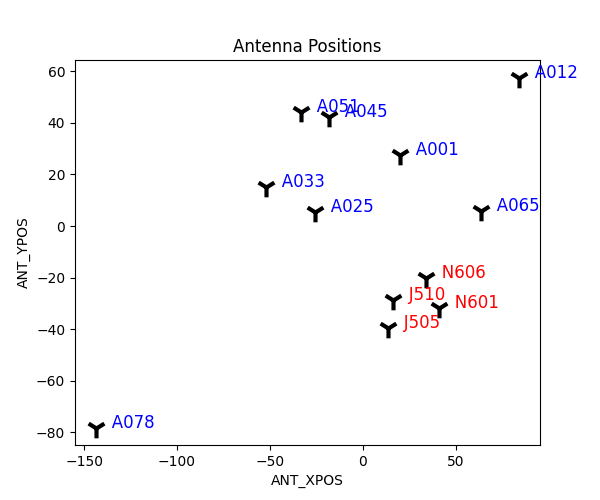

In [23]:
from sirius._sirius_utils._gen_utils import _x_plot
_x_plot(vis=save_parms['ms_name'], ptype='plotants')

Completed ddi 0  process time 4.87 s.ATA...SPECTRAL_WINDOW_ID...                    
Completed subtables  process time 7.37 s...                                     
                                                  
overwrite_encoded_chunks True


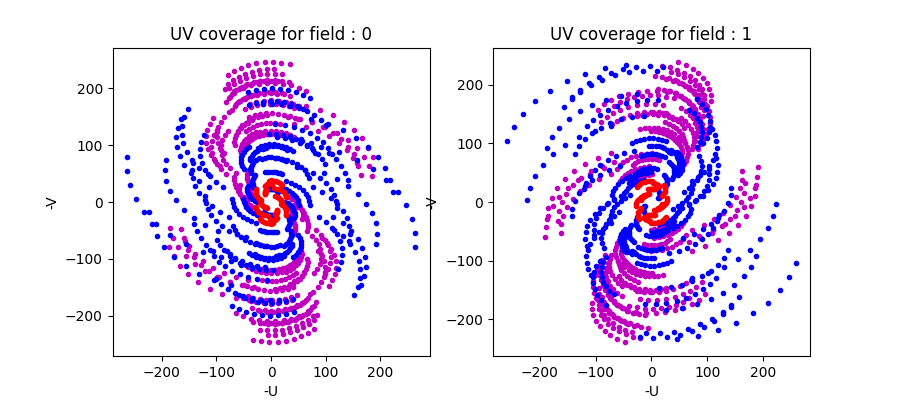

In [29]:
from sirius._sirius_utils._gen_utils import _x_plot
_x_plot(vis=save_parms['ms_name'], ptype='uvcov',forceconvert=True)

In [44]:
from sirius._sirius_utils._gen_utils import _listobs_jupyter
_listobs_jupyter(vis=save_parms['ms_name'])

           MeasurementSet Name:  /users/jsteeb/sirius/docs/het_mosaic_sim.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: ALMA(12 antennas)
Data records: 1188       Total elapsed time = 36000 seconds
   Observed from   03-Oct-2020/18:39:56.4   to   04-Oct-2020/04:39:56.4 (UTC)

Fields: 2
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         fake1               19:59:28.500000 -40.44.01.50000 J2000   0            594
  1         fake2               19:59:28.500000 -40.44.51.50000 J2000   1            594
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      Band3      5   TOPO   90000.000   2000000.000  10000000.0  94000.0000   XX  YY
Antennas: 12 'name'='station' 
   ID=   0-4: 'A001'='P', 'A012'='P', 'A025'='P', 'A033'='P', 'A045'='P', 
   ID=   5-9: 'A051'='P', 'A065'='P